## Connecting to the Database

In [1]:
pip install psycopg2-binary;

  Using cached psycopg2_binary-2.8.6-cp37-cp37m-manylinux1_x86_64.whl (3.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import psycopg2

In [3]:
# Put the password in 
PGHOST = 'tripdatabase2.cmaaautpgbsf.us-east-2.rds.amazonaws.com'
PGDATABASE = ''
PGUSER = 'postgres'
PGPASSWORD = 'Josh1234'

In [4]:
# Database Context Manager
try:   
    # Set up a connection to the postgres server.    
    conn = psycopg2.connect(user = PGUSER,
                            port = "5432",
                            password = PGPASSWORD,
                            host = PGHOST,
                            database = PGDATABASE)
    # Create a cursor object
    cursor = conn.cursor()   
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("Connection Success:", record,"\n")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)

Connection Success: ('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',) 



## Basic Exploratory Analysis

In [5]:
import pandas as pd
import numpy as np
import Queries
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

In [6]:
services = ['bay', 'blue', 'capital', 'citi', 'divvy']

### Trips Per Month Over the Years

In [58]:
trips_per_month = pd.DataFrame(columns= ['year_month', 'trips', 'bikeshare'])

for service in services:
    trip_per_month_query = f"""
            SELECT DATE_TRUNC('month', starttime) as year_month, 
                   COUNT(*) as trips, '{service}' as bikeshare
              FROM trips.{service}_trip
             GROUP BY year_month
             ORDER BY year_month;
            """
    trips_per_month = trips_per_month.append(Queries.execute_query(conn, trip_per_month_query, to_frame=True))

trips_per_month.trips = trips_per_month.trips.astype('int32')

In [59]:
# Plot when CitiBike reaches their 1M mark
# Plot when CitiBike reaches their 100M mark
# Highlight different lines based on season
# Possibly do a quick time series analysis
# Overlay the temperature data on top and possible do a return analysis


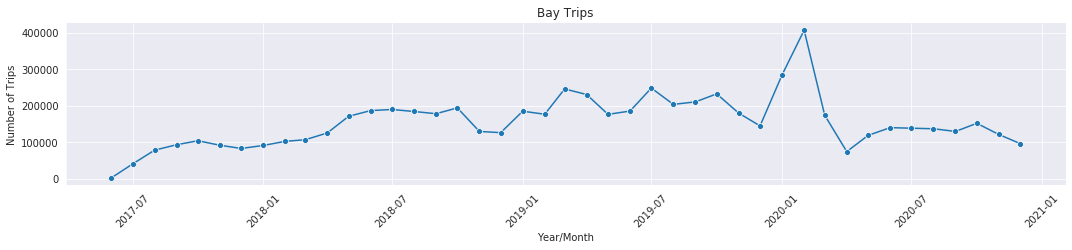

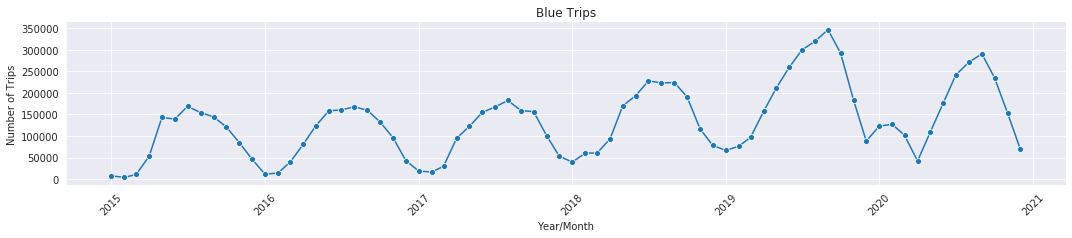

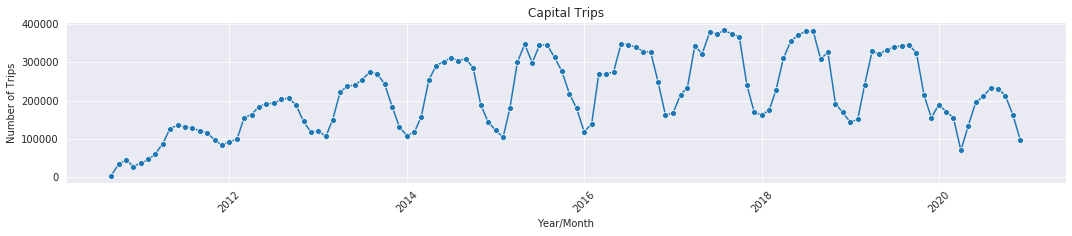

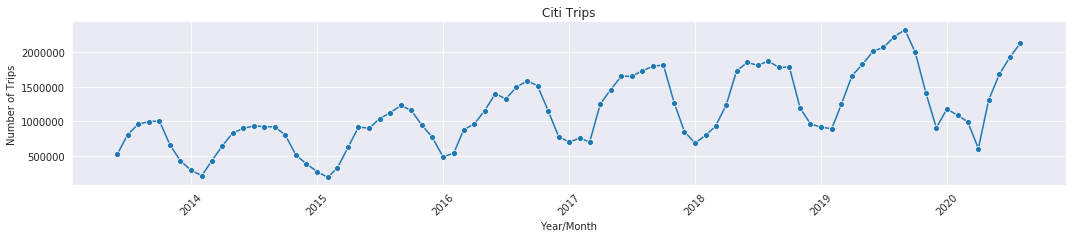

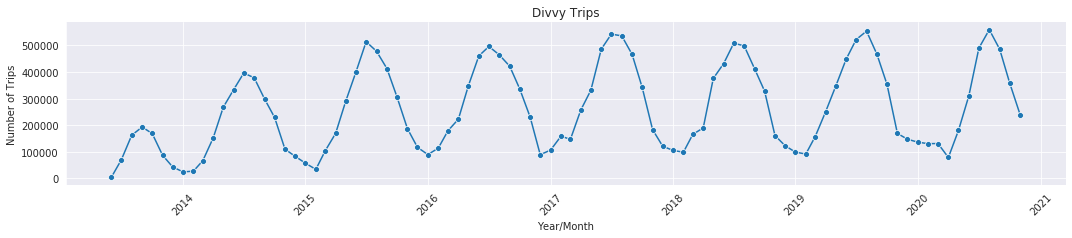

In [66]:
sns.set_style('darkgrid')

for service in services:
    g = sns.relplot('year_month','trips', data= trips_per_month[trips_per_month.bikeshare==service], kind='line', height=3, aspect = 5, marker='o')
    
    g.set(xlabel = 'Year/Month', ylabel = "Number of Trips", title = service.title() + ' Trips')
    g.set_xticklabels(rotation=45)

Observations
- The number of trips taken throughout the year for each service, exccept BayWheels, ebbs and flows. An explanation for this may be the chnging of the seasons in those four cities (Boston, Washington D.C, New York City, Chicago) from winter to summer and back. Temperatures begin to rise into spring and reaches its heights in summer so does the number of trips. When temperature drops going into winter the number of trips follow. BayWheels is located in the San Francisco area and the winter climate there is mild and rainy, more comparable to the spring climate in the other cities. 


- Prior to effects of COVID-19, over time, both the peaks and the troughs for the four services that have seasonality were gradually getting higher. Impling that the bike service is getting used more each year. Except in Chicago (Divvy), where both peask and troughs appear to be relatively equal. 

- In the first months of 2020 the number of trips didn't follow its usual behavior of a relatively steady rise starting in Jan/Feb and had a massive drop off going in April. The most likely cause of that was the impact of COVID-19 on the cities and the lockdowns that were being implemented.

### Trips Per Hour

In [67]:
trips_per_hour = pd.DataFrame(columns = ['hour', 'trips', 'bikeshare'])

for service in services:
    trip_per_hour_query = f"""
            SELECT EXTRACT(HOUR FROM starttime) as hour, count(*) as trips, '{service}' as bikeshare
              FROM trips.{service}_trip
             GROUP BY hour
             ORDER BY hour;
            """
    trips_per_hour = trips_per_hour.append(Queries.execute_query(conn, trip_per_hour_query, to_frame=True))

trips_per_hour.trips = trips_per_hour.trips.astype('int32')

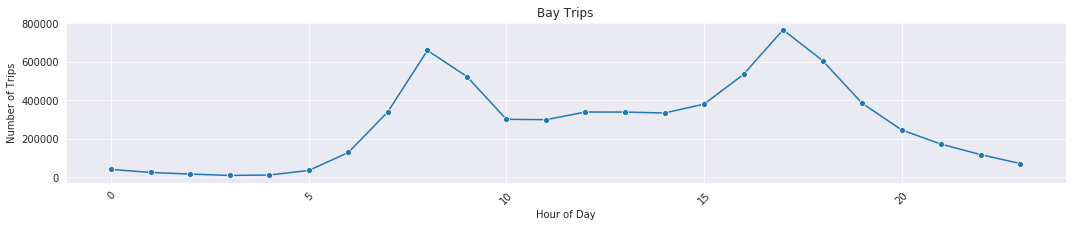

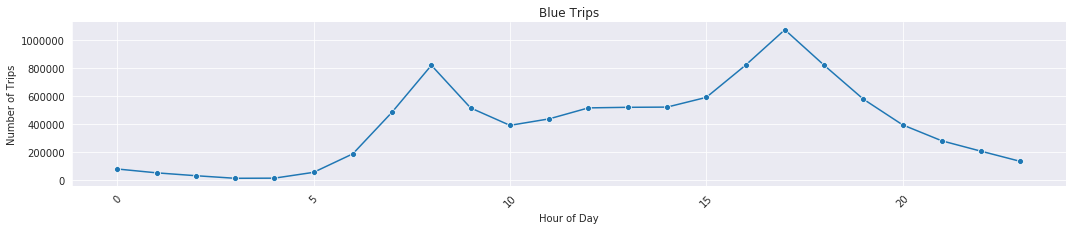

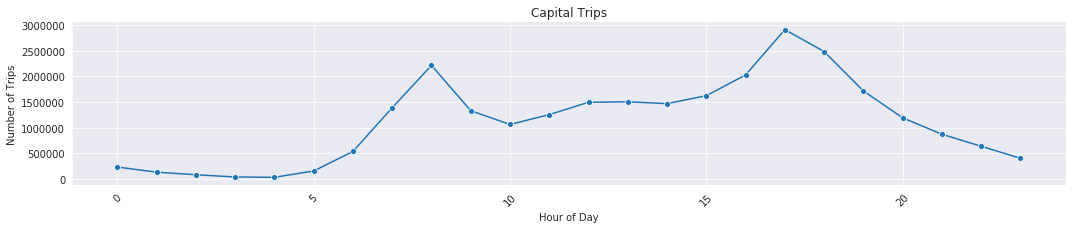

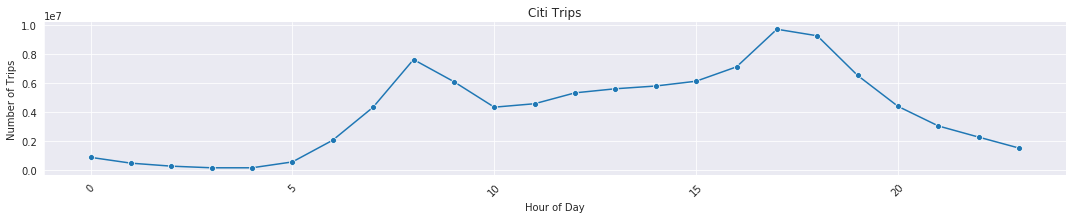

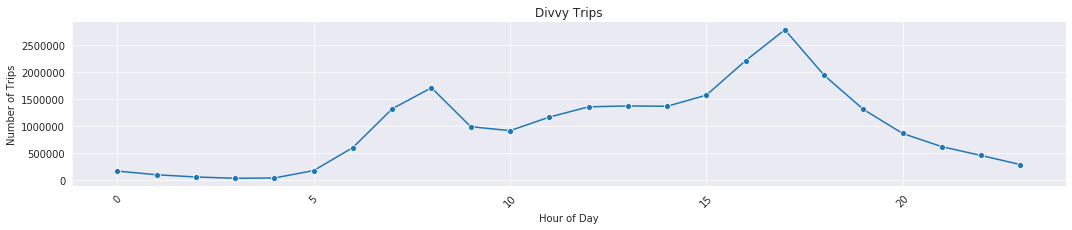

In [72]:
for service in services:
    g = sns.relplot('hour','trips', data= trips_per_hour[trips_per_hour.bikeshare==service], kind='line', height=3, aspect = 5, marker='o')
    
    g.set(xlabel = 'Hour of Day', ylabel = "Number of Trips", title = service.title() + ' Trips')
    g.set_xticklabels(rotation=45)

Daily Hour Pattern - *Across all Services*
- The # of trips begins to ramp up starting at 6AM hour and hits its first peak during the 8AM hour.
- From the 9AM to 3PM hours the number of trips seems to be stable.
- After 3PM the # of trips begin to ramp up starting at 4PM and reaches daily highs during 5/6PM hours.
- After 5/6PM the # of trips slowly begins to taper off and the process repeats itself. 

What's so special about 6-8AM and 4-6PM that causes the number of trips to increase? The answer is Rush Hour. "Normally it happens twice every weekday; once in the morning and once in the afternoon or evening, the times during which the most people communte...Rush hour may be 6-10AM and 3-7PM...The frequency of public transport service is usually higher in the rush hour..."

https://en.wikipedia.org/wiki/Rush_hour

### Trips Per Hour Conditional on the Day
In the last block we looked at the overall trip behavior per hour for all time. Now lets look at the trip behavior per hour based on each day and see if there is any difference. 

In [74]:
trip_per_hour_cond = pd.DataFrame(columns=['day','hour','trips', 'bikeshare'])
                                  
for service in services:
    trip_per_hour_query = f"""
            SELECT EXTRACT(DOW FROM starttime) as day, EXTRACT(HOUR FROM starttime) as hour, count(*) as trips, '{service}' as bikeshare
              FROM trips.{service}_trip
             GROUP BY day, hour
             ORDER BY day, hour;
            """
    trip_per_hour_cond = trip_per_hour_cond.append(Queries.execute_query(conn, trip_per_hour_query, to_frame=True))
                                  
trip_per_hour_cond = trip_per_hour_cond.astype({'trips':'int32', 'hour':'int32'})          

In [75]:
mapping = {
    0:'Sunday',
    1:'Monday',
    2:'Tuesday',
    3:'Wednesday',
    4:'Thursday',
    5:'Friday',
    6:'Saturday'
}
trip_per_hour_cond.day = trip_per_hour_cond.day.map(mapping)

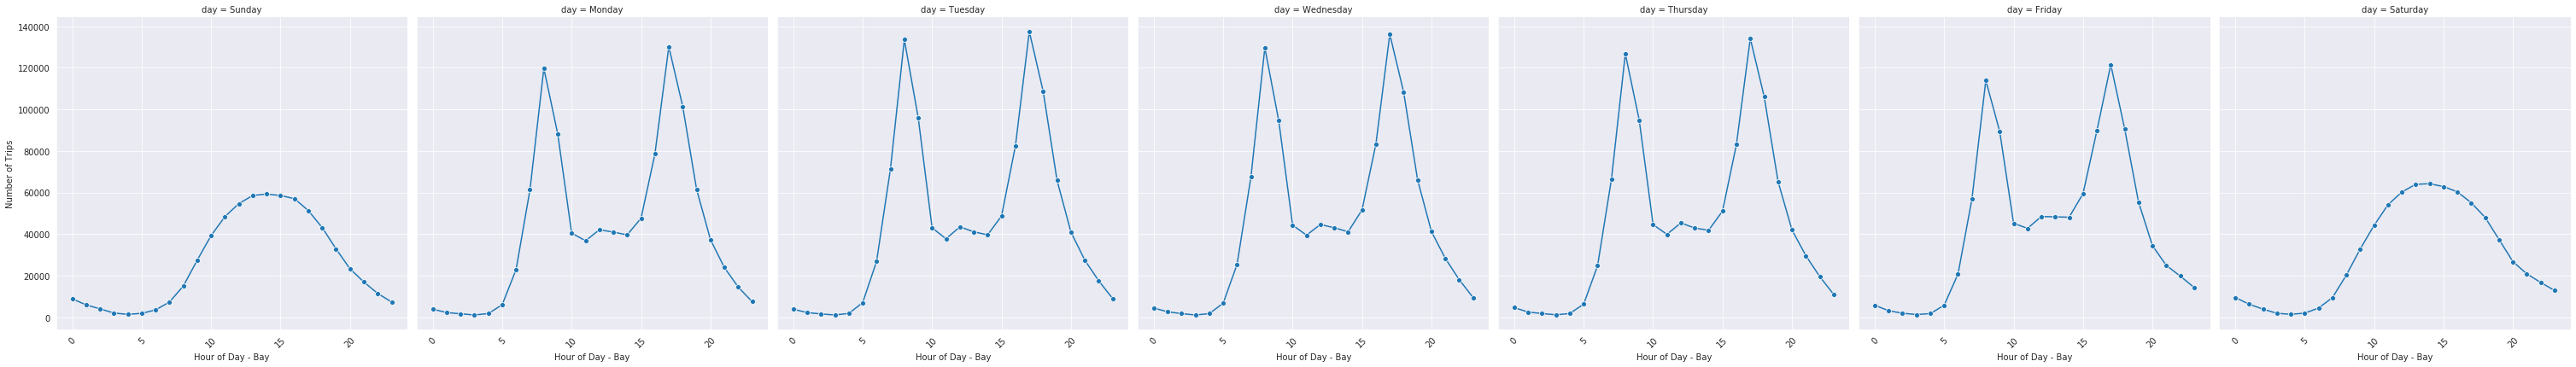

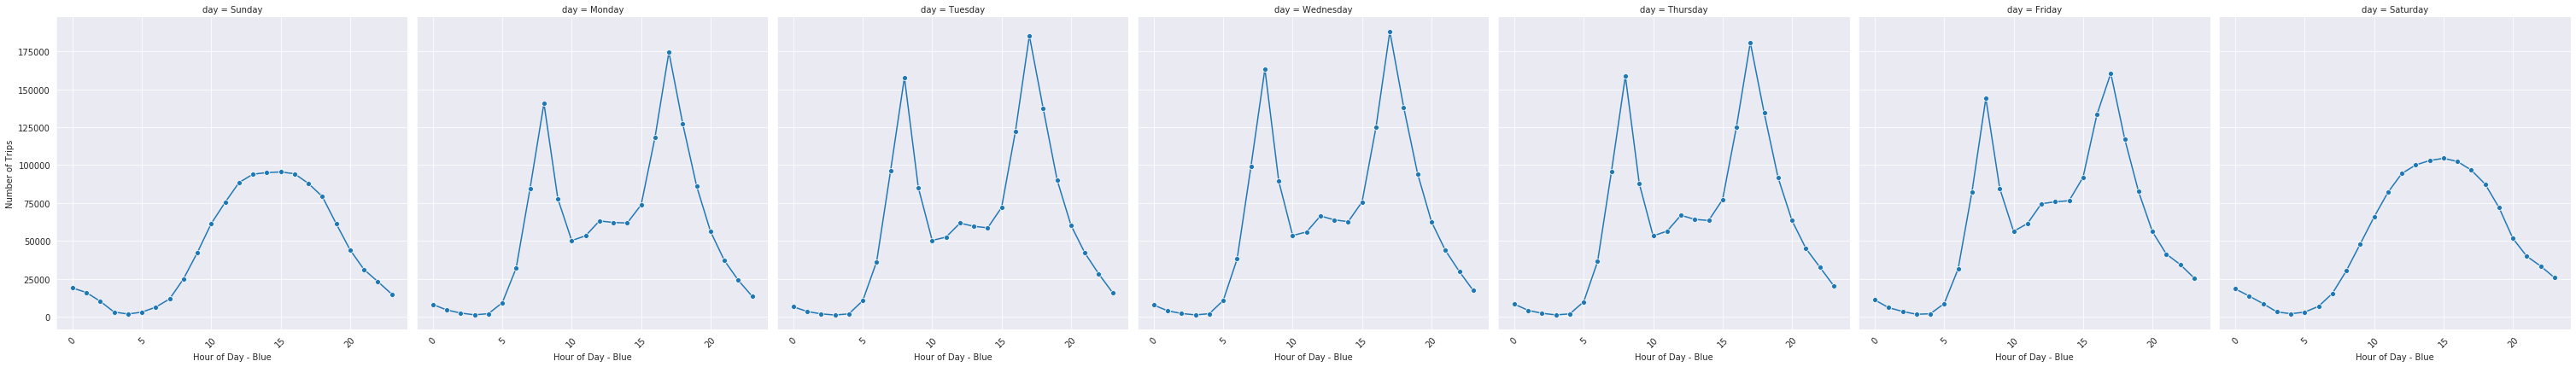

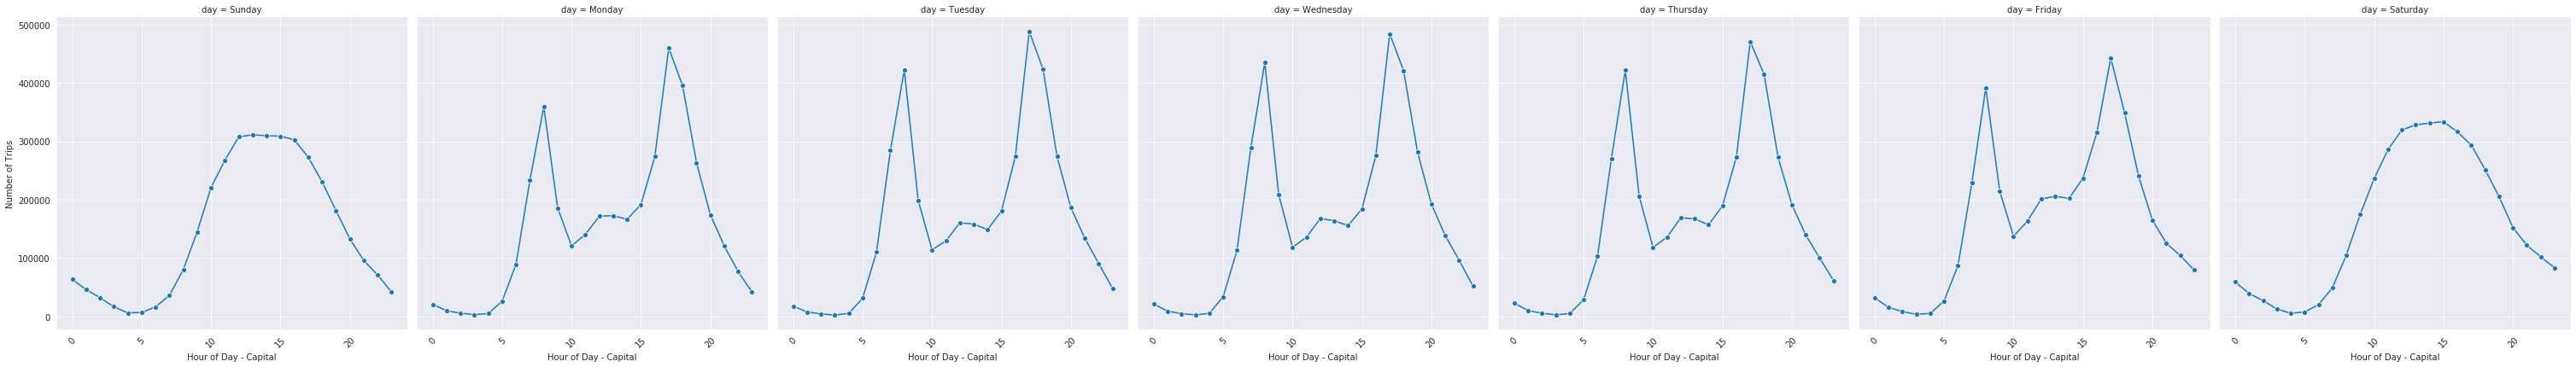

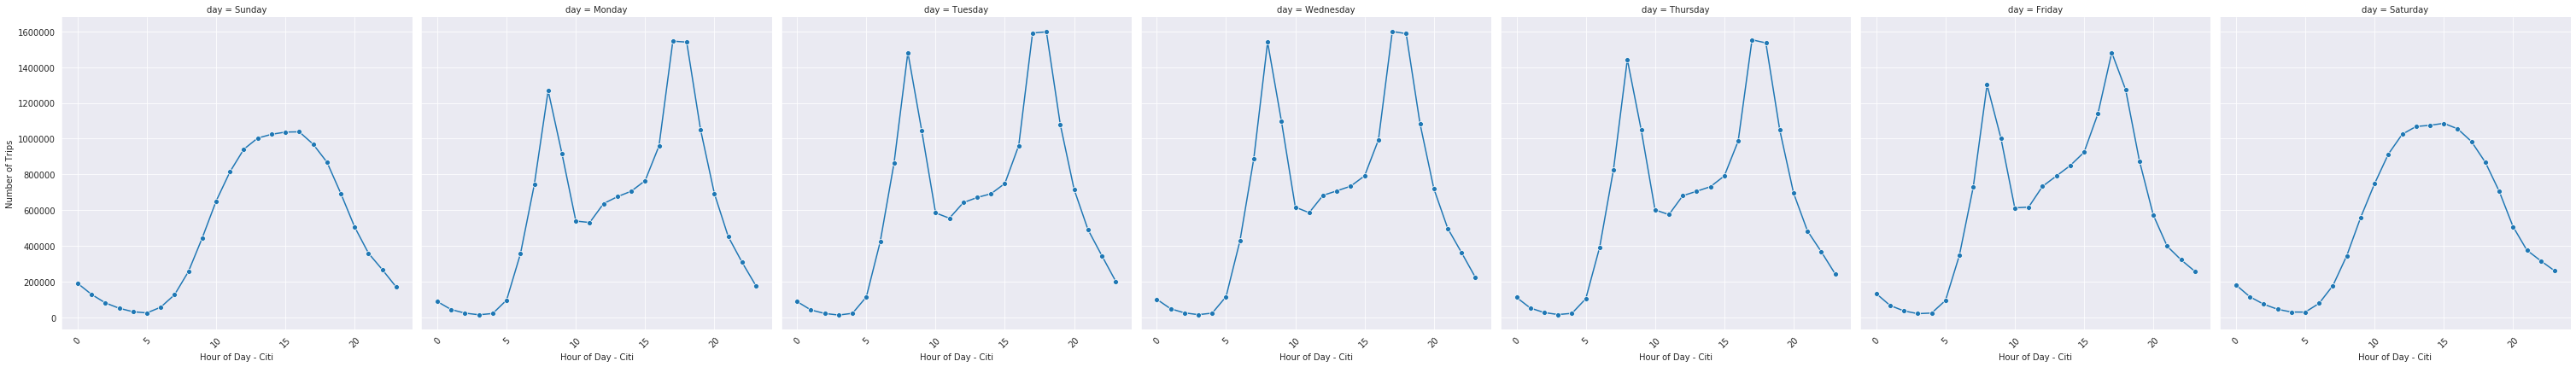

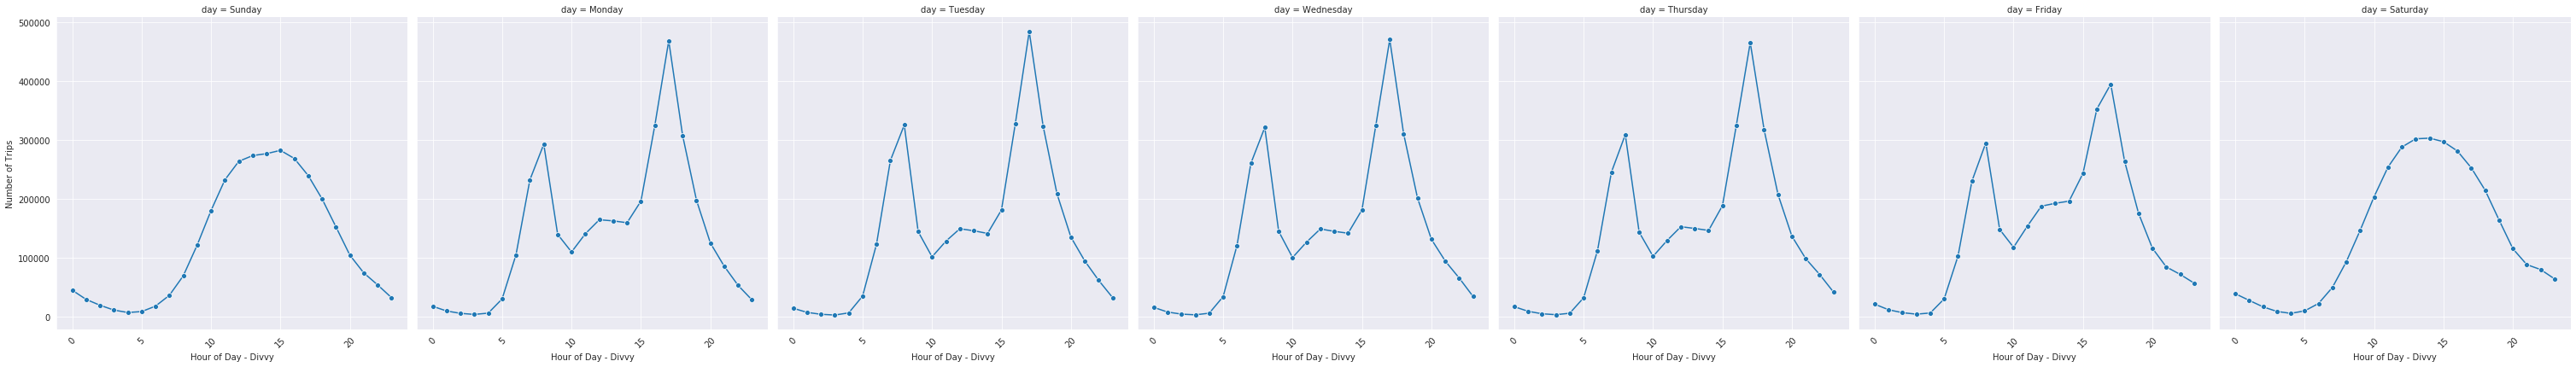

In [93]:
for service in services:
    g = sns.relplot('hour','trips', data= trip_per_hour_cond[trip_per_hour_cond.bikeshare==service], col='day', kind='line', height=6, aspect = 1, marker='o')
    
    g.set(xlabel = f'Hour of Day - {service.title()}', ylabel = "Number of Trips")
    g.set_xticklabels(rotation=45)

Hour Pattern by Day of Week - *Across All Stations*
- The weekdays tend to have a similar structure and the weekends have a similar structure
- The weekends don't have that sharp rises and declines that the weekdays do. The # of trips gradually rises and then gradually falls. 

When it comes to CitiBike, the absence of a second peak on Friday stands out from the other weekdays. Normally there are a high number of trips during the 5 and 6 pm hours before the decline, but on Friday there is only one peak at 5pm. If peaks in trips represent when people are traveling to and from work, it seems that people don't waste anytime leaving work on Friday evening. 

## Station Growth

In [53]:
station_growth = pd.DataFrame(data = {'year': ['2010-01-01', '2011-01-01', '2012-01-01',
                                      '2013-01-01', '2014-01-01', '2015-01-01',
                                      '2016-01-01', '2017-01-01', '2018-01-01',
                                      '2019-01-01', '2020-01-01']})

station_growth.year = pd.to_datetime(station_growth.year, infer_datetime_format = True)

for service in services:
    station_growth_query = f"""
        SELECT 
          DATE_TRUNC('year', birth) as year,
          count(birth) as {service}
        FROM
          stations.{service}_station
        GROUP BY year
        ORDER BY year;
        """
    
    df = Queries.execute_query(conn, station_growth_query, to_frame = True)
    station_growth = station_growth.merge(df, how='left', on='year')

station_growth.fillna(0, inplace=True)

In [54]:
station_growth

,year,bay,blue,capital,citi,divvy
0,2010-01-01,0.0,0.0,106,0.0,0.0
1,2011-01-01,0.0,0.0,38,0.0,0.0
2,2012-01-01,0.0,0.0,50,0.0,0.0
3,2013-01-01,0.0,0.0,111,338.0,300.0
4,2014-01-01,0.0,0.0,41,0.0,0.0
5,2015-01-01,0.0,156.0,11,154.0,175.0
6,2016-01-01,0.0,34.0,78,172.0,106.0
7,2017-01-01,272.0,11.0,53,186.0,5.0
8,2018-01-01,28.0,114.0,42,52.0,32.0
9,2019-01-01,119.0,66.0,54,157.0,10.0


## How Many People Does Each Station Serve

When people use public transportation they go to the spot that is most convient for them. Typically conveient means the closet. I saw typically because there are times when people have to go farther distances to catch a bus or train that has a different route than the one closet to them. However, in the case of bike share there is no incentive to go to a bike station that is farther away from the one that closet to you. With that being said, a station only serves the people that are closer to it than to any other station. We will define a station's service by the equation $$S(s) = \sum_{i=1}^{N}\frac{A(G_i \cap V_s)}{A(G_i)} \cdot P_i$$ where $S(s)$ is the number of people served by station $s$, $N$ is the number of neighborhoods in NYC, $A$ is the area function, $G_i$ is the geometry polygon for neighborhood $i$, $V_s$ is the voronoi polygon for station $s$, $P_i$ is the population for neighborhood $i$. 

For every station we need to iterate through every neighborhood and:
- Intersect the geometry of the neighborhood with the voronoi geometry
- Find the area of the intersection
- Divide that area by the area of the neighborhood geometry
- Muliply that number by the population of the neighborhood
- Save the number

### Step 1: Determine the Voronoi Polygons for each Station
**Note: We are only getting voronoi polygons for stations that are still active (station.death IS NULL)**

In [ ]:
add_voronoi_column_query = """
        ALTER TABLE station
        ADD COLUMN voronoi GEOMETRY;
        """
Queries.execute_query(conn, add_voronoi_column_query)

In [175]:
Queries.voronoi_data(conn)

In [11]:
voronoi_requirements = """
        SELECT stationid, voronoi as geometry
        FROM station
        WHERE voronoi IS NOT NULL;
        """
voronoi_data = gpd.read_postgis(voronoi_requirements, conn, geom_col='geometry')
voronoi_data.to_crs(32118, inplace=True); # The SRID in the database is 4326

### Step 2: Gather All the Neighborhood Data Needed
**Note: We are only looking at neighborhoods that have stations.**

In [12]:
hood_requirements = """
        SELECT n.code, p.dem14 AS population, n.geometry as geometry
          FROM neighborhood AS n
          LEFT JOIN profile AS p
               ON n.code = p.code
         WHERE n.code IN (
               SELECT DISTINCT CODE 
                 FROM station
               );
        """
hood_data = gpd.read_postgis(hood_requirements, conn, geom_col='geometry')
hood_data.to_crs(32118,inplace=True);
hood_data['area'] = hood_data['geometry'].area

### Step 3: The Intersection Function
This function takes a single station's voronoi polygon and intersections it with every neighborhood. It then finds the area of each individual polygon

In [13]:
def intersection(voronoi: gpd.GeoDataFrame(), boroughs: gpd.GeoDataFrame()):
    # The polygons of intersection between the voronoi and all the neighborhoods
    # returns a df all the neighborhoods the station's voronoi intersects as well as the geometry and area of the intersection
    res_intersection = gpd.overlay(voronoi, boroughs, how='intersection')
    res_intersection['inter_area'] = res_intersection['geometry'].area
    return res_intersection

### Step 4: The People Served Function
This function merges the hood_data with the intersection data and calculates the people served for each row. 

In [14]:
def people_served(inter_df) -> int:
    # Takes in the intersection df and merges the neighborhood geometry data
    # Then calculates the riders for each intersection based on the formula
    # Groups by the stationid (one group) and sum them -> returns that df
    merged = inter_df.merge(hood_data[['code','geometry','area']], on='code', suffixes=['_inter','_reg'])
    merged['riders'] = round(merged.area_inter / merged.area_reg * merged.population)
    group = merged.groupby('stationid').apply(sum).reset_index(drop=True)
    return (group)

### Step 5: People Served for Every Station

In [15]:
station_query = """
        SELECT stationid, name, code, geometry
          FROM STATION 
         WHERE voronoi IS NOT NULL;
        """

stations = gpd.read_postgis(station_query, conn, geom_col='geometry')
stations.to_crs(32118,inplace=True);
stations = stations.astype({'stationid':'int'})
stations.set_index('stationid',inplace=True)
stations['riders'] = 0
stations['borough'] = stations.code.str[:2]

In [16]:
stations_lst = list(stations.index)

In [17]:
for station in stations_lst[:]:
    df = intersection(voronoi_data[voronoi_data.stationid==station], hood_data) 
    stations.loc[station,'riders'] = people_served(df).riders[0]

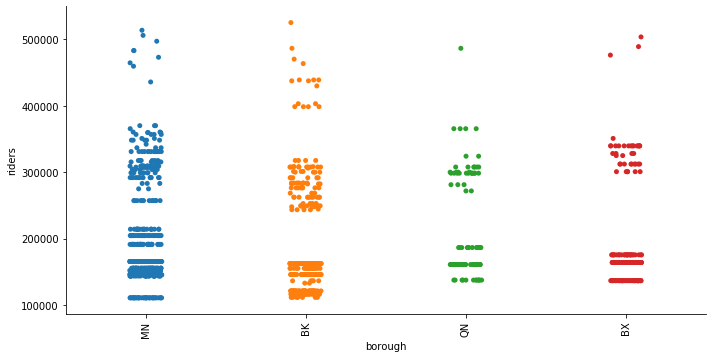

In [69]:
g = sns.catplot(x='borough', y='riders',data=stations, kind='strip', height=5, jitter=True, aspect=2, orient='v')
g.set_xticklabels(rotation=90);

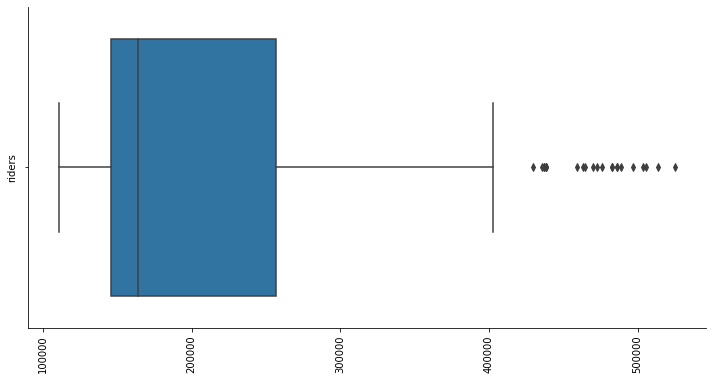

In [70]:
g = sns.catplot(y='riders',data=stations, kind='box', height=5, aspect=2, orient='h')
g.set_xticklabels(rotation=90);

From the two graphs we can see that the majority of stations serve between 100,000 and 250,000 people, that covers about 75% of the stations via the boxplot. In the stripplot there is group of stations that serve between 250,000 and 350,000 people. The 'people served' stastic on its own isn't very useful. It's difficult to tell if a station with a higher statistic has a bigger voronoi area or has a smaller voronoi area in a denser part of the city. A better statistic to look at would be the ratio between the riders served and the area of the voronoi

In [16]:
stations = stations.merge(voronoi_data, left_index=True, on='stationid',how='left', suffixes=('_point','_voronoi'))
stations = gpd.GeoDataFrame(stations)
stations.set_index('stationid',inplace=True)

In [17]:
stations['v_area'] = stations.geometry_voronoi.area
stations['riders_per_sqm'] = stations.riders/stations.v_area

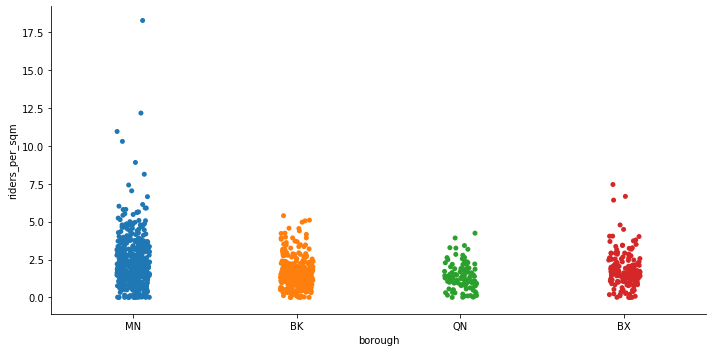

In [74]:
g = sns.catplot(x='borough', y='riders_per_sqm',data=stations, kind='strip', height=5, jitter=True, aspect=2, orient='v')

When we looked at just riders served the data was really spread out, looking at the ratio between the riders and the area of the voronoi the data is tight. Regardless of the borough, regardless of the location the number of people that a station is rarely over 0.50 people per square meter of it's voronoi. Which makes practical sense, because the denser the population of an area the more stations you need to accomodate the population. The more stations packed into one area, the smaller the voronoi area. Although, the area is small it is still serving tons of people. This leads me to believe that population density is an extremely important factor when the company chooses the number of and the locations of stations in an area. 

*It may even lead to an interesting optimization problem where we are trying to find the number of and locations of a station in an area such that the ratio between people served and voronoi are is under 0.50 sq meters*

### Step 6: How Many Actual Riders

## Would You Have Bike Access
What is the probability that a randomly selected New Yorker lives within a certain distance of a station? We are going to pick a random person from the city, represented as a point. We will then create a buffer around the point and see if there are any stations within that buffer. Not only will we do this process with citibike stations we will do it with MTA Subway Entrances as well and see how they compare. 

### Step 1: Gathering all the Neighborhood Data
Although we already have half of the needed neighborhood data from the previous section, let's regather everything in this section so that it is clear. We are going to call the neighborhood df that has all the neighborhoods of NYC **hood_data_A**. We are going to call the neighborhood df that only has neighborhoods that have stations **hood_data_S**. 

In [9]:
hood_A_query = """
        SELECT n.code, p.dem14 AS population, n.geometry as geometry
          FROM neighborhood AS n
          LEFT JOIN profile AS p
               ON n.code = p.code;
        """
hood_data_A = gpd.read_postgis(hood_A_query, conn, geom_col='geometry', index_col='code')
hood_data_A.to_crs(32118,inplace=True)

In [10]:
hood_S_query = """
        SELECT n.code, p.dem14 AS population, n.geometry as geometry
          FROM neighborhood AS n
          LEFT JOIN profile AS p
               ON n.code = p.code
         WHERE n.code IN (
               SELECT DISTINCT CODE 
                 FROM station
                WHERE death IS NULL
               );
        """
hood_data_S = gpd.read_postgis(hood_S_query, conn, geom_col='geometry', index_col='code')
hood_data_S.to_crs(32118,inplace=True);

### Step 2: Gather the Different Transit Data

In [10]:
station_query = """
        SELECT stationid, geometry
          FROM STATION 
         WHERE death IS NULL;
        """

stations = gpd.read_postgis(station_query, conn, geom_col='geometry')
stations.to_crs(32118,inplace=True);
stations = stations.geometry

In [12]:
geofile = "s3://williams-citibike/Subway_Entrances.geojson"

with fs.open(geofile, 'rb') as file:
    subway = gpd.read_file(file)

subway.to_crs(32118, inplace=True)
subway = subway.geometry

### Step 2: The Probabilities of Choosing a Person
The probabilitiy of picking someone in nyc is not equal across all neighborhoods. The denser the neighborhood the more likely a random person will be picked from there. We need to come up with the probability that a person will be picked from a neighborhood based on the population. Additionally, these probabilities will be differnent depending on whether we choose to take the subset of neighborhoods are all the neighborhoods.

In [13]:
import random

In [14]:
neighborhoods = [None]*2   # A two-length list of lists, the first list being the names of the boroughs in hood_data_A
probabilities = [None]*2   # A two-length list of lists, the first list being the probabilities of the boroughs in hood_data_A

In [15]:
total_pop = hood_data_A.population.sum()
neighborhoods[0] = list(hood_data_A.index)
probabilities[0] = list(hood_data_A.population / total_pop)

In [16]:
total_pop = hood_data_S.population.sum()
neighborhoods[1] = list(hood_data_S.index)
probabilities[1] = list(hood_data_S.population / total_pop)

### Step 3: Actually Choosing a Person

In [17]:
def random_person(neighborhoods: list, prob: list) -> shapely.geometry.Point():
    code = np.random.choice(neighborhoods, 1, prob)[0]   # First pick a random neighborhood
    poly = hood_data_A.loc[code,'geometry']
    minx, miny, maxx, maxy = poly.bounds
    
    while True:
        p = shapely.geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))   # Pick a random point inside the bounds
        if poly.contains(p):
            return p

### Step 4: Check if there is a Station within a Radius

In [18]:
def has_station(p: shapely.geometry.Point(), transit: list, radius: float=805):
    """ radius is in meters and the buffer uses the radius to create a circular area"""
    buf = p.buffer(radius)

    for location in transit:
        if buf.contains(location):
            return True
    
    return False

### Step 5: Run the Experiments

In [19]:
def trials(rounds: int, per_round: int, neighborhoods: list, prob: list, transit: gpd.GeoSeries() , radius: float=805):
    results = []

    for i in range(rounds): # The rounds of the experiment
        total = 0

        for j in range(per_round): # The experiment is to pick 10000 people and see if they live within a station
            person = random_person(neighborhoods, prob)
            total += has_station(person, transit, radius)
        
        total /= per_round
        results.append(total)
    
    return results

In [20]:
radius = [805,604,402,201,80]
cA = []   # idx=0, stations
cS = []   # idx=1, stations
sA = []   # idx=0, subway
sS = []   # idx=1, subway

In [21]:
for r in radius:
     w = trials(100,100, neighborhoods[0], probabilities[0], stations, r)
     cA.append((r,np.mean(w)))

In [23]:
for r in radius:
    x = trials(100,100, neighborhoods[1], probabilities[1], stations, r)
    cS.append((r,np.mean(x)))

In [25]:
for r in radius:
    y = trials(100,100, neighborhoods[0], probabilities[0], subway, r)
    sA.append((r,np.mean(y)))


In [27]:
for r in radius:
    z = trials(100,100, neighborhoods[1], probabilities[1], subway, r)
    sS.append((r,np.mean(z)))

The four different combinations of data and the five different distances used as a buffer are shown in the table below along with the results of the experiment.

<table>
    <tr> 
        <th rowspan=2;> Distances (miles) </th>
        <th colspan=2;> CitiBike</th>
        <th colspan=2;> Subway</th>
    </tr>
    <tr>
        <th style="text-align: center;">All Hoods</th>
        <th style="text-align: center;">Hoods w/ Stations</th>
        <th style="text-align: center;">All Hoods</th>
        <th style="text-align: center;">Hoods w/ Stations</th>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.5 (805m)</td>
        <td style="text-align: center;">41%</td>
        <td style="text-align: center;">83%</td>
        <td style="text-align: center;">67%</td>
        <td style="text-align: center;">85%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.375 (604m)</td>
        <td style="text-align: center;">39%</td>
        <td style="text-align: center;">80%</td>
        <td style="text-align: center;">58%</td>
        <td style="text-align: center;">76%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.25 (402m) </td>
        <td style="text-align: center;">36%</td>
        <td style="text-align: center;">76%</td>
        <td style="text-align: center;">43%</td>
        <td style="text-align: center;">59%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.125 (201m)</td>
        <td style="text-align: center;">28%</td>
        <td style="text-align: center;">59%</td>
        <td style="text-align: center;">17%</td>
        <td style="text-align: center;">26%</td>
    </tr>
    <tr>
        <td style="text-align: center;"> 0.05 (80m) </td>
        <td style="text-align: center;">6%</td>
        <td style="text-align: center;">15%</td>
        <td style="text-align: center;">4%</td>
        <td style="text-align: center;">6%</td>
    </tr>
    

</table>